# Model parameterization examples: soft clipping and B-splines

In [1]:
import sys

pwd = !echo ${PWD}
sys.path.append(pwd[0]+"/../../../code/local/bin")

In [2]:
import numpy as np
import math
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seppy

sep = seppy.sep()

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

# Create directories to store data and figures
!mkdir -p ../dat ../fig

datapath=pwd[0]+"/../dat/"
figpath=pwd[0]+"/../fig/"
executable=pwd[0]+"/../../../code/local/bin"

### Soft-clip operator

In [3]:
def basicClip(x,n=3):
    y = x - (x**n)/n
    select = np.abs(x)>=1
    y[select] = np.sign(x[select])*(n-1.)/n
    return y

def mapping(x,vmin=-1,vmax=1,n=3, inv=False):
    vmid=0.5*(vmin+vmax)
    Dv = vmax-vmin
    if inv==True:
        y = 0.5*Dv*np.sign(x)*np.abs(x)**(1./n) + vmid
    else:
        y=(2*(x-vmid)/Dv)**n
    return y

def softClip(x,vmin=-1,vmax=1,n1=3,n2=3):
    vbar = 0.5*(vmin+vmax)
    dv = (vmax - vbar)*((n1-1.)/n1)**(-1./n2)
    vmin0 = vbar-dv
    vmax0 = vbar+dv
    g = mapping(x,vmin0,vmax0,n2,False)
    f = basicClip(g,n1)
    y = mapping(f,vmin0,vmax0,n2,True)
    return y

In [4]:
x=np.linspace(-1.5,1.5,100)
yhard=x.copy()
yhard[yhard<-1]=-1
yhard[yhard>1]=1
y3=basicClip(x,n=3)
y7=basicClip(x,n=7)

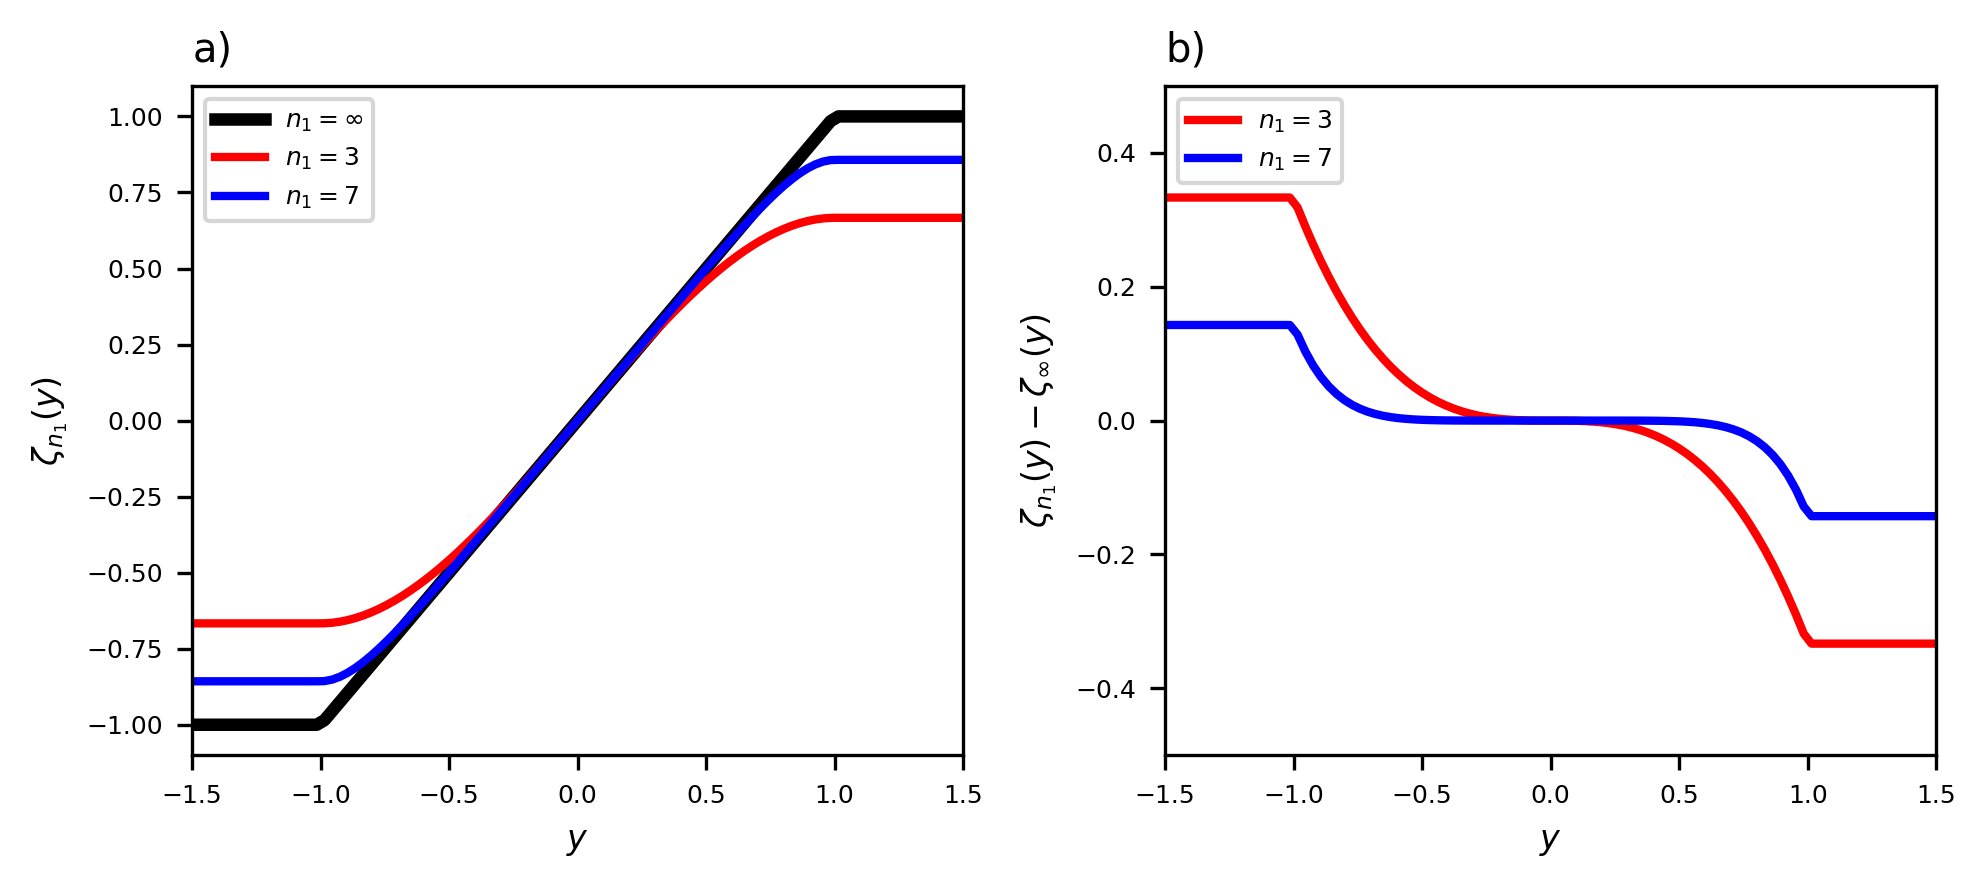

In [5]:
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig=plt.figure(figsize=(6.66, 3),dpi=300)

plt.subplot(1,2,1)
plt.plot(x,yhard,label=r"$n_1=\infty$",linewidth=3,linestyle='-',c='k')
plt.plot(x,y3,label=r"$n_1=3$",linewidth=2,c='r')
plt.plot(x,y7,label=r"$n_1=7$",linewidth=2,c='b')
# plt.hlines(-1,-1.5,-1, linewidth=1, linestyles='--', colors='k')
# plt.hlines(+1,1,1.5, linewidth=1, linestyles='--', colors='k')
plt.xlim([-1.5,1.5])
# plt.ylim([-1.5,1.5])
plt.xlabel(r"$y$")
plt.ylabel(r"$\zeta_{n_1}(y)$")
plt.legend(loc='upper left',prop={'size': 6})
plt.title(r"a)",loc='left')
plt.gca().tick_params(axis='both', which='major', labelsize=6)

plt.subplot(1,2,2)
plt.plot(x,y3-yhard,label=r"$n_1=3$",linewidth=2,c='r')
plt.plot(x,y7-yhard,label=r"$n_1=7$",linewidth=2,c='b')
plt.xlim([-1.5,1.5])
plt.ylim([-0.5,0.5])
# plt.gca().set_yticklabels([])
plt.xlabel(r"$y$")
plt.ylabel(r"$\zeta_{n_1}(y)-\zeta_{\infty}(y)$")
plt.legend(loc='upper left',prop={'size': 6})
plt.title(r"b)",loc='left')
plt.gca().tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

plt.savefig(figpath+'soft_clip_basic.png',bbox_inches='tight',format='png')

In [6]:
vmin=2
vmax=6
x=np.linspace(vmin-1,vmax+1,100)
yhard=x.copy()
yhard[yhard<vmin]=vmin
yhard[yhard>vmax]=vmax
y3=softClip(x,vmin, vmax, n1=3, n2=3)
y7=softClip(x,vmin, vmax, n1=7, n2=7)

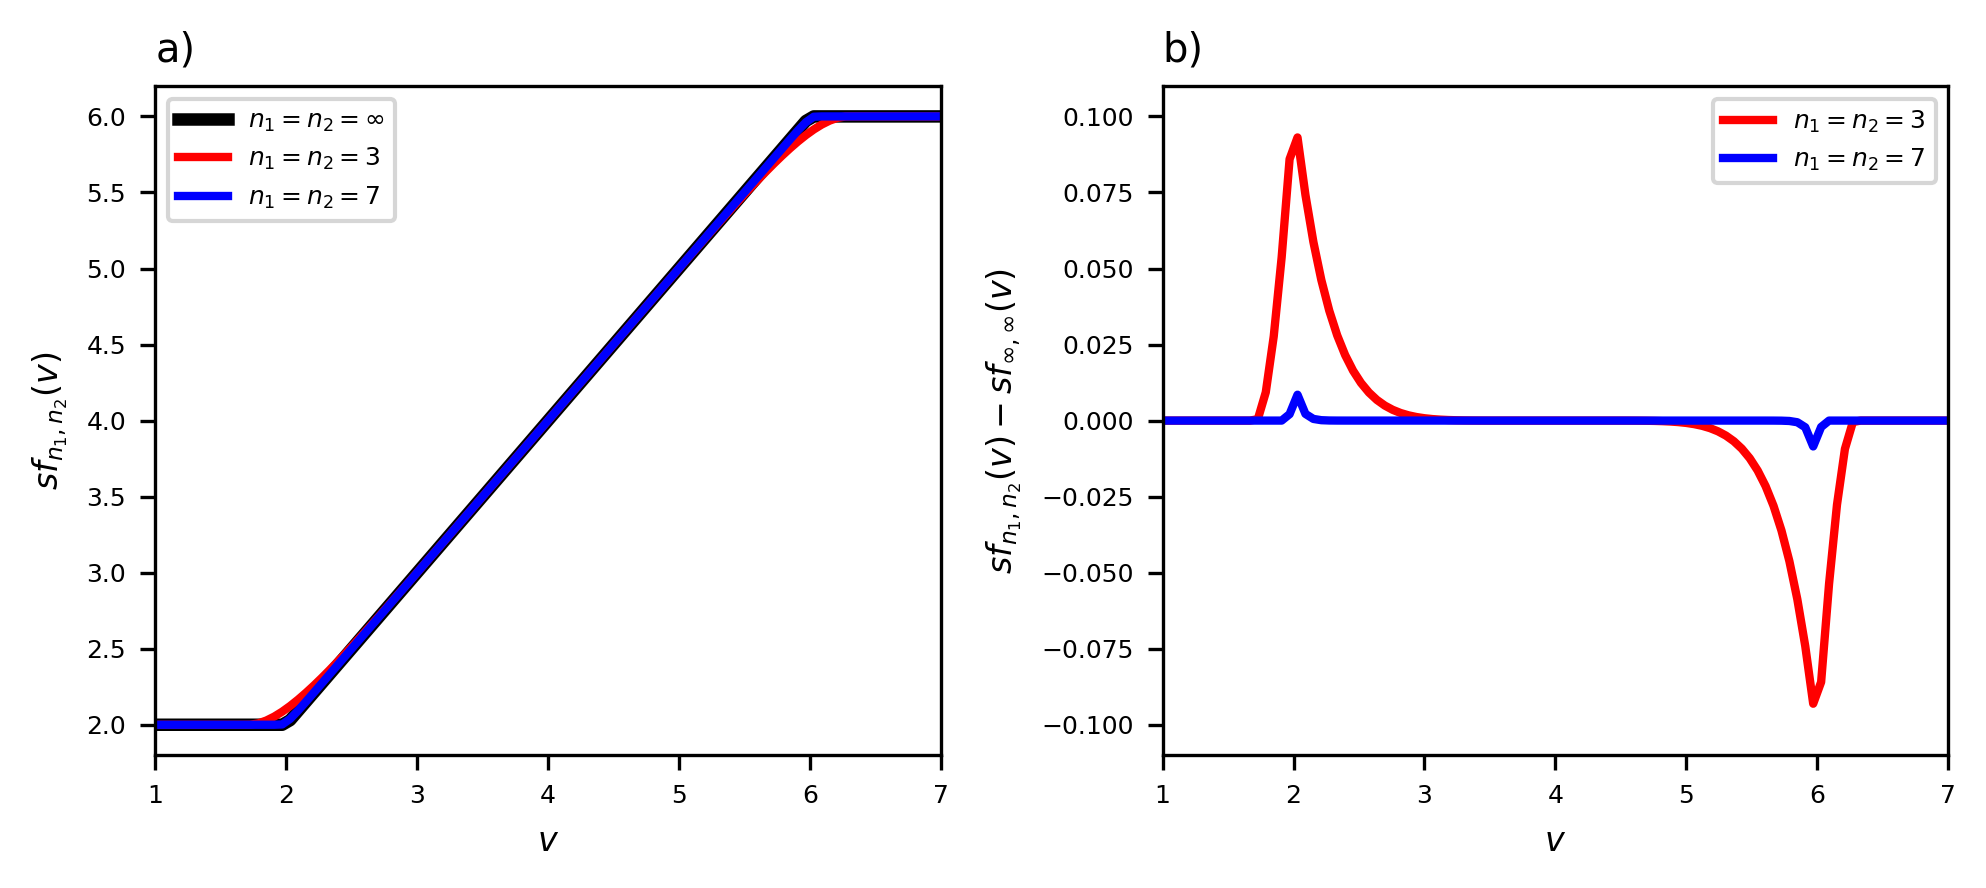

In [7]:
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig=plt.figure(figsize=(6.66, 3),dpi=300)

plt.subplot(1,2,1)
plt.plot(x,yhard,label=r"$n_1=n_2=\infty$",linewidth=3,linestyle='-',c='k')
plt.plot(x,y3,label=r"$n_1=n_2=3$",linewidth=2,c='r')
plt.plot(x,y7,label=r"$n_1=n_2=7$",linewidth=2,c='b')
plt.xlim([1,7])
plt.xlabel(r"$v$")
plt.ylabel(r"$sf_{n_1,n_2}(v)$")
plt.legend(loc='upper left',prop={'size': 6})
plt.title(r"a)",loc='left')
plt.gca().tick_params(axis='both', which='major', labelsize=6)

plt.subplot(1,2,2)
plt.plot(x,y3-yhard,label=r"$n_1=n_2=3$",linewidth=2,c='r')
plt.plot(x,y7-yhard,label=r"$n_1=n_2=7$",linewidth=2,c='b')
plt.xlim([1,7])
plt.ylim([-0.11,0.11])
# plt.gca().set_yticklabels([])
plt.xlabel(r"$v$")
plt.ylabel(r"$sf_{n_1,n_2}(v)-sf_{\infty,\infty}(v)$")
plt.legend(loc='upper right',prop={'size': 6})
plt.title(r"b)",loc='left')
plt.gca().tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

plt.savefig(figpath+'soft_clip_final.png',bbox_inches='tight',format='png')

### B-spline interpolation operator

In [8]:
# create a random 1D profile
seed=1234
np.random.seed(seed)

n=53
m = np.random.rand(n)
m += 1
m[20:30] += 1
m = signal.savgol_filter(m,7, 2)

In [9]:
# save profile to SEPlib
sep.write_file(datapath+"profile.H", np.transpose(m), ds=np.array([1]), os=np.array([0]), dpath=datapath)

In [10]:
# perform B-spline smoothing S.p with p a subsamples version of m 
!${PWD}/../../../code/local/bin/BSPLINES.x < ../dat/profile.H nx=0 nz=14 bsoutput=../dat/profile1.H.bs output=../dat/profile1.H datapath=${PWD}/../dat/

# perform B-spline smoothing S.p with p a LS solution of S.p=m 
!${PWD}/../../../code/local/bin/BSPLINES.x < ../dat/profile.H nx=0 nz=14 niter=20 bsoutput=../dat/profile2.H.bs output=../dat/profile2.H datapath=${PWD}/../dat/

Iteration = 0; functional = 0.451683; normalized functional = 1
Iteration = 1; functional = 0.285434; normalized functional = 0.631935
Iteration = 2; functional = 0.240093; normalized functional = 0.531552
Iteration = 3; functional = 0.227391; normalized functional = 0.503431
Iteration = 4; functional = 0.2131; normalized functional = 0.471791
Iteration = 5; functional = 0.20745; normalized functional = 0.459282
Iteration = 6; functional = 0.205419; normalized functional = 0.454786
Iteration = 7; functional = 0.204918; normalized functional = 0.453676
Iteration = 8; functional = 0.204814; normalized functional = 0.453446
Iteration = 9; functional = 0.204781; normalized functional = 0.453374
Iteration = 10; functional = 0.204774; normalized functional = 0.453357
Iteration = 11; functional = 0.204773; normalized functional = 0.453356
Iteration = 12; functional = 0.204773; normalized functional = 0.453355
Iteration = 13; functional = 0.204773; normalized functional = 0.453355
Iteration = 

In [11]:
# load the profiles
axes, data = sep.read_file(datapath+"profile1.H")
m1 = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"profile1.H.bs")
m1bs = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"profile2.H")
m2 = data.reshape(axes.n,order='F').T

axes, data = sep.read_file(datapath+"profile2.H.bs")
m2bs = data.reshape(axes.n,order='F').T

<ipython-input-12-a3419fa81c69>:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(xbs,m1bs,basefmt=" ",label=r"$\mathbf{p}=\mathbf{Km}$",markerfmt='bo',linefmt='b--')
<ipython-input-12-a3419fa81c69>:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(xbs,m2bs,basefmt=" ",label=r"$\mathbf{p}=\mathbf{P}^{\dagger}\mathbf{m}$",markerfmt='bo',linefmt='b--')


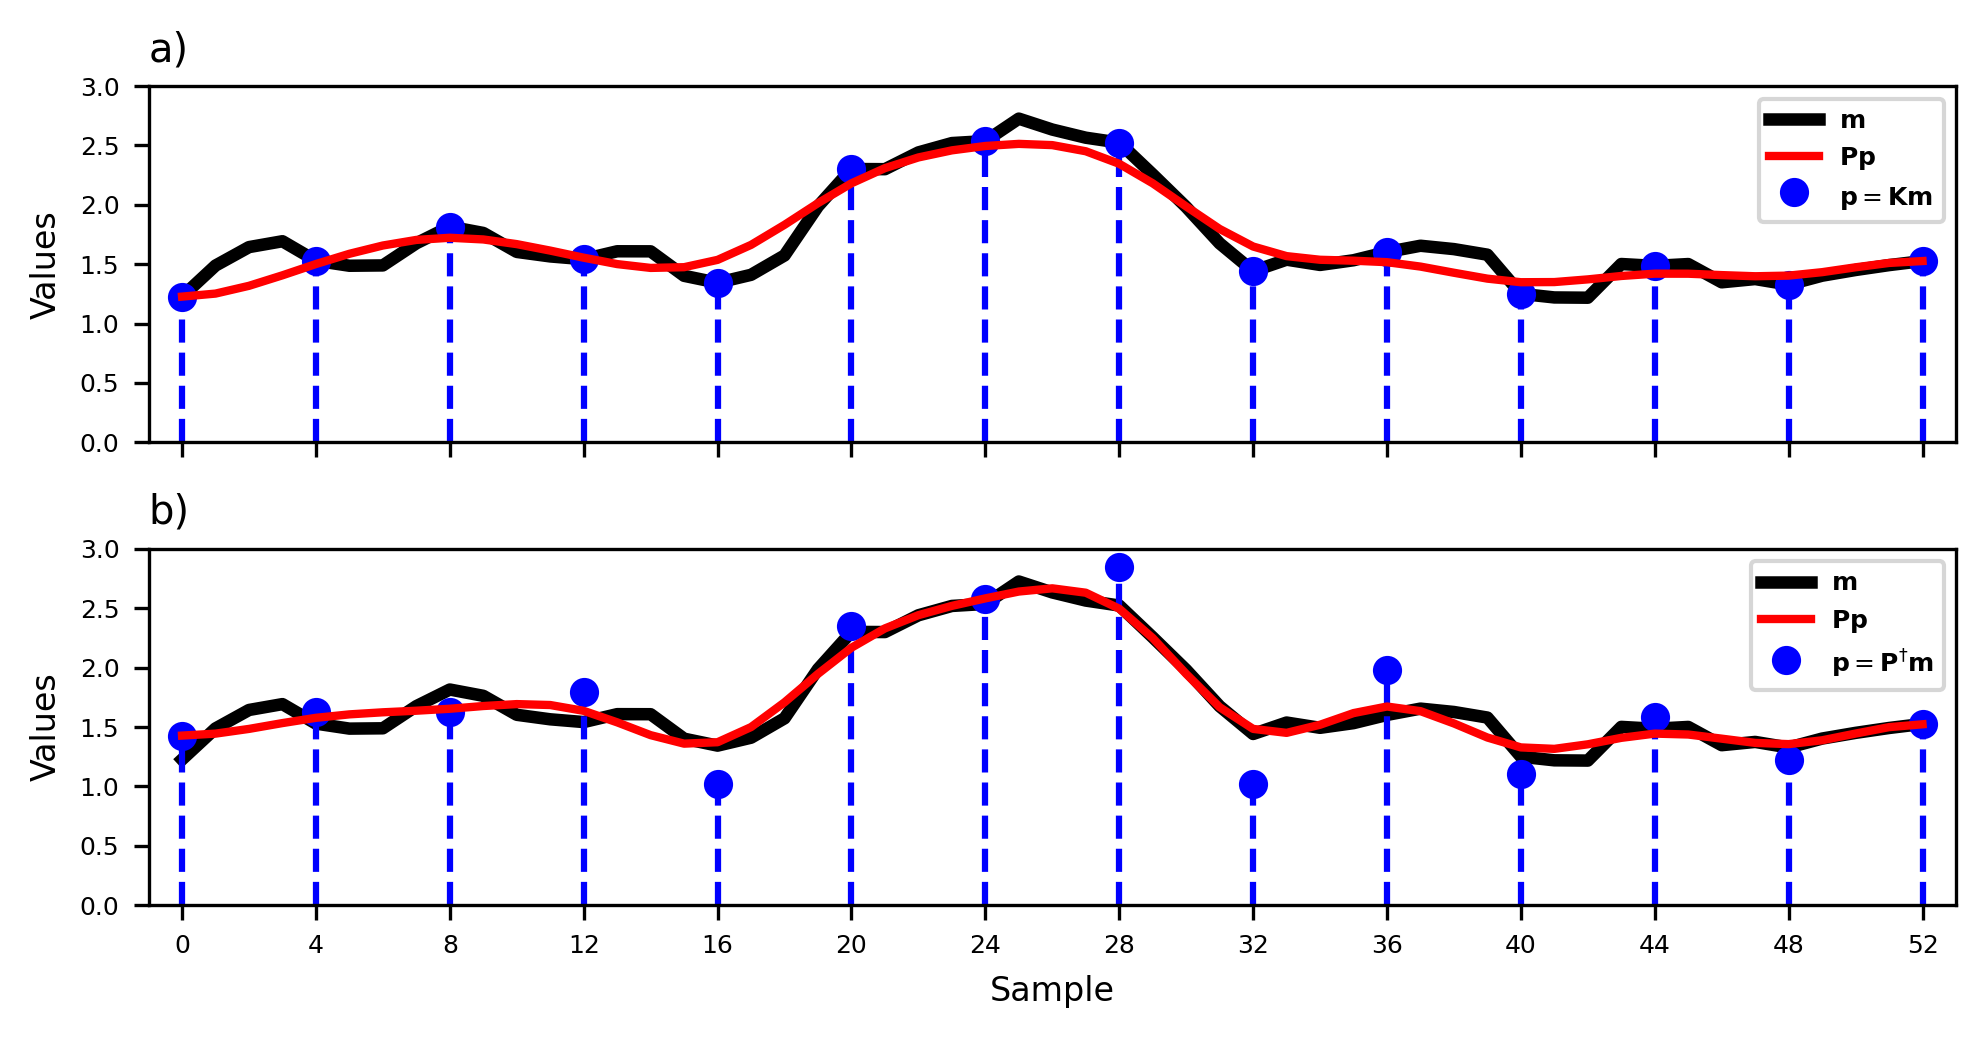

In [12]:
x = np.linspace(0,n-1,n)
xbs = np.linspace(0,n-1,14)

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig=plt.figure(figsize=(6.66, 3.5),dpi=300)

plt.subplot(2,1,1)
plt.plot(x,m,label=r"$\mathbf{m}$",linewidth=3,linestyle='-',c='k')
plt.stem(xbs,m1bs,basefmt=" ",label=r"$\mathbf{p}=\mathbf{Km}$",markerfmt='bo',linefmt='b--')
plt.plot(x,m1,label=r"$\mathbf{Pp}$",linewidth=2,c='r')
plt.xlim([-1,n])
plt.ylim([0,3])
plt.gca().set_xticklabels([])
plt.ylabel(r"Values")
plt.legend(loc='upper right',prop={'size': 6})
plt.title(r"a)",loc='left')
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gca().xaxis.set_ticks(xbs)

plt.subplot(2,1,2)
plt.plot(x,m,label=r"$\mathbf{m}$",linewidth=3,linestyle='-',c='k')
plt.stem(xbs,m2bs,basefmt=" ",label=r"$\mathbf{p}=\mathbf{P}^{\dagger}\mathbf{m}$",markerfmt='bo',linefmt='b--')
plt.plot(x,m2,label=r"$\mathbf{Pp}$",linewidth=2,c='r')
plt.xlim([-1,n])
plt.ylim([0,3])
plt.xlabel(r"Sample")
plt.ylabel(r"Values")
plt.legend(loc='upper right',prop={'size': 6})
plt.title(r"b)",loc='left')
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gca().xaxis.set_ticks(xbs)

plt.tight_layout()

plt.savefig(figpath+'bsplines.png',bbox_inches='tight',format='png')

### Horizon extrapolation operator

In [13]:
# source parameters
nt=201 # number of time samples
dt=0.005 # sampling rate (sec)
f0=10. # peak frequency (Hz)
shift=25 # shift wavelet (number of samples)

# background model parameters
alpha=3500. # P-wave velocity (m/sec)
rho=2000. # density (kg/m3)

# source wavelet
w=np.zeros(nt)
pi = math.pi
tshift=shift*dt
sig=math.sqrt(2)/(2*f0*pi)
t=np.linspace(0,(nt-1)*dt,nt)
w=(1.0 - ((t-tshift)/sig)**2)*np.exp( -0.5*((t-tshift)/sig)**2)

# background acoustic model and mask
nx=101
nz=101
model0=np.zeros((2,nx,nz))
model0[0,:,:]=alpha/1000. # Vp in km/s
model0[1,:,:]=rho/1000. # density in g/cc
mask=np.zeros((2,nx,nz))
mask[0,:,:]=1

# create a random 1D profile
seed=4321
np.random.seed(seed)
m = 4*(np.random.rand(nz)-0.5)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
m = np.convolve(m, kernel, mode='same')
m = np.convolve(m, kernel, mode='same')
m = np.convolve(m, kernel, mode='same')
model1 = np.copy(model0)
for i in range(nx):
    model1[0,i,:] += m

# create a random horizon
hrz=np.zeros(nx)+0.5
hrz += 0.5*np.random.rand(nx)
kernel_size = 13
kernel = np.ones(kernel_size) / kernel_size
hrz = ndimage.convolve1d(hrz, kernel, mode='reflect')
hrz = ndimage.convolve1d(hrz, kernel, mode='reflect')
hrz = ndimage.convolve1d(hrz, kernel, mode='reflect')
hrz = ndimage.convolve1d(hrz, kernel, mode='reflect')

In [14]:
# save wavelet and models to SEPlib
sep.write_file(datapath+"source.H", np.transpose(w), ds=np.array([dt]), os=np.array([0]), dpath=datapath)
sep.write_file(datapath+"model0.H", np.transpose(model0), ds=np.array([0.01,0.01,1]), os=np.array([0,0,0]), dpath=datapath)
sep.write_file(datapath+"model1.H", np.transpose(model1), ds=np.array([0.01,0.01,1]), os=np.array([0,0,0]), dpath=datapath)
sep.write_file(datapath+"mask.H", np.transpose(mask), ds=np.array([0.01,0.01,1]), os=np.array([0,0,0]), dpath=datapath)
sep.write_file(datapath+"hrz.H", np.transpose(hrz), ds=np.array([0.01]), os=np.array([0]), dpath=datapath)

In [15]:
# generate pressure data from the background model
!${PWD}/../../../code/local/bin/WE_MODELING.x source=../dat/source.H model=../dat/model0.H output=../dat/data0.H datapath=${PWD}/../dat/ \
verbose=0 \
ns=2 sx0=0.25 sz0=0.3 szinc=0.4 nr=31 rx0=0.75 rz0=0.2 rzinc=0.02 \
bc_top=2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=30 taper_bottom=30 taper_left=25 taper_right=25 taper_strength=0.1

--------------------------------------------------------------------------
[[22986,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0


In [16]:
# build a horizon conformal model by running a dummmy 0 iteration 1.5D FWI
!${PWD}/../../../code/local/bin/FWI2D.x source=../dat/source.H model=../dat/model1.H data=../dat/data0.H horizon=../dat/hrz.H output=../dat/model2.H datapath=${PWD}/../dat/ \
verbose=0 \
ns=2 sx0=0.25 sz0=0.3 szinc=0.4 nr=31 rx0=0.75 rz0=0.2 rzinc=0.02 \
bc_top=2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=30 taper_bottom=30 taper_left=25 taper_right=25 taper_strength=0.1 \
inversion1d=1 niter=0

--------------------------------------------------------------------------
[[22792,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0


In [17]:
# generate pressure data from the true model
!${PWD}/../../../code/local/bin/WE_MODELING.x source=../dat/source.H model=../dat/model2.H output=../dat/data2.H datapath=${PWD}/../dat/ \
verbose=0 \
ns=2 sx0=0.25 sz0=0.3 szinc=0.4 nr=31 rx0=0.75 rz0=0.2 rzinc=0.02 \
bc_top=2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=30 taper_bottom=30 taper_left=25 taper_right=25 taper_strength=0.1

--------------------------------------------------------------------------
[[22854,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0


In [18]:
# run 2D FWI
!${PWD}/../../../code/local/bin/FWI2D.x source=../dat/source.H model=../dat/model0.H data=../dat/data2.H horizon=../dat/hrz.H mask=../dat/mask.H output=../dat/fwi2d.H datapath=${PWD}/../dat/ \
verbose=0 \
ns=2 sx0=0.25 sz0=0.3 szinc=0.4 nr=31 rx0=0.75 rz0=0.2 rzinc=0.02 \
bc_top=2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=30 taper_bottom=30 taper_left=25 taper_right=25 taper_strength=0.1 \
inversion1d=0 niter=20

--------------------------------------------------------------------------
[[22660,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0


In [19]:
# run 1.5D FWI
!${PWD}/../../../code/local/bin/FWI2D.x source=../dat/source.H model=../dat/model0.H data=../dat/data2.H horizon=../dat/hrz.H mask=../dat/mask.H output=../dat/fwi1d.H datapath=${PWD}/../dat/ \
verbose=0 \
ns=2 sx0=0.25 sz0=0.3 szinc=0.4 nr=31 rx0=0.75 rz0=0.2 rzinc=0.02 \
bc_top=2 bc_bottom=2 bc_left=2 bc_right=2 taper_top=30 taper_bottom=30 taper_left=25 taper_right=25 taper_strength=0.1 \
inversion1d=1 niter=20

--------------------------------------------------------------------------
[[22725,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: vision

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0


In [20]:
# load models
axes, data = sep.read_file(datapath+"model2.H")
data = data.reshape(axes.n,order='F').T
model2=data[0,:,:]

axes, data = sep.read_file(datapath+"fwi2d.H")
data = data.reshape(axes.n,order='F').T
fwi2d=data[0,:,:]

axes, data = sep.read_file(datapath+"fwi1d.H")
data = data.reshape(axes.n,order='F').T
fwi1d=data[0,:,:]

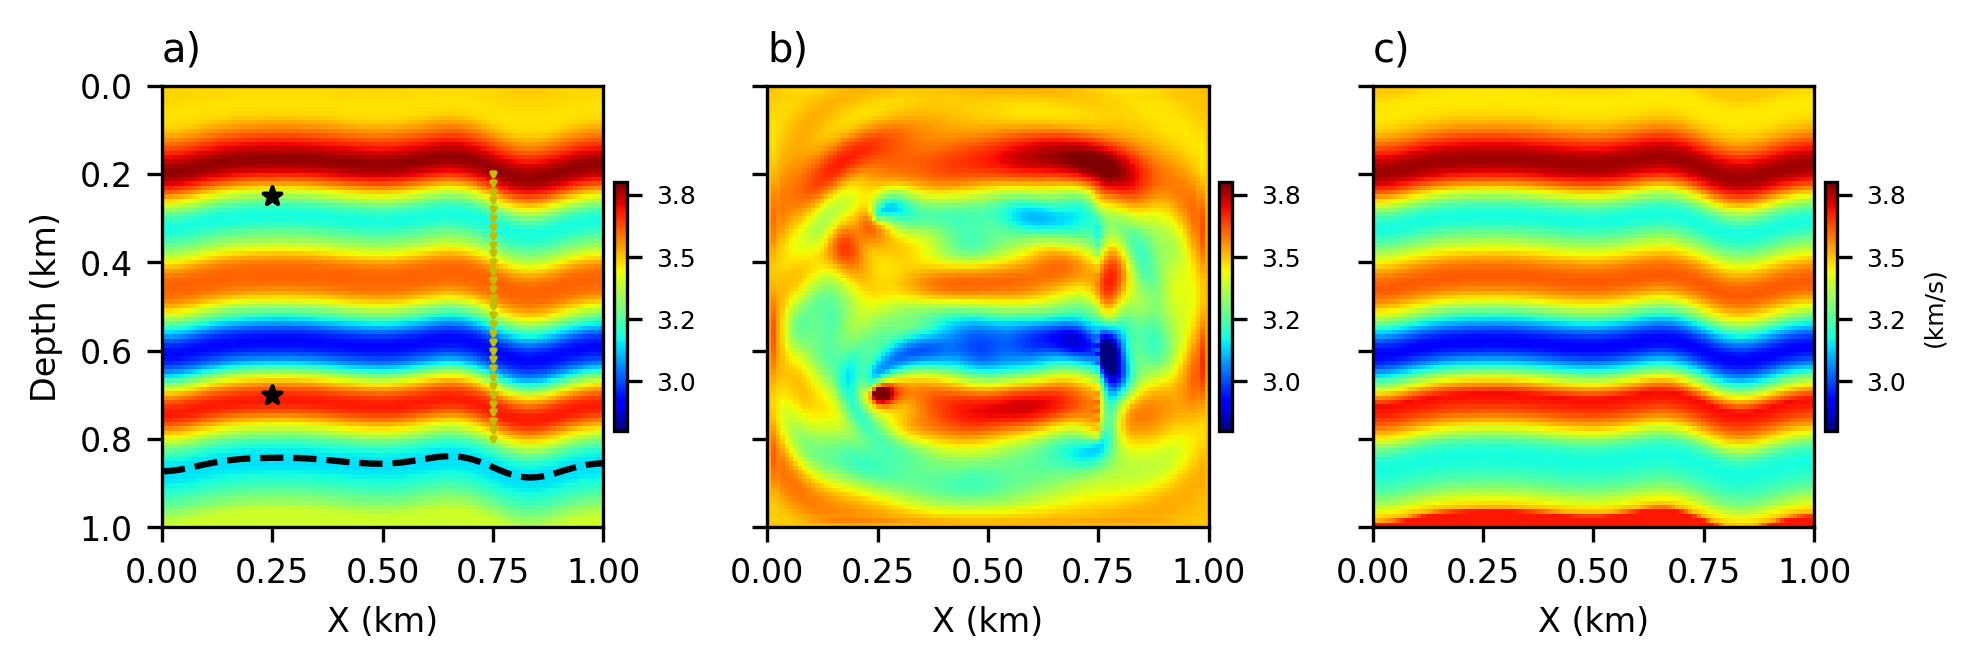

In [21]:
vmin=2.8
vmax=3.8

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig=plt.figure(figsize=(6.66, 3),dpi=300)

plt.subplot(1,3,1)
plt.imshow(np.transpose(model2), extent=[0,1,1,0], cmap='jet', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.3, format="%.1f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
# cbar.set_label(label="(km/s)",size=6)
plt.plot(np.linspace(0,1,nx), 0.1+hrz,'k--')
plt.scatter([0.25,0.25],[0.25,0.7], marker='*', s=20,c='k')
plt.scatter(np.linspace(0.75,0.75,31),np.linspace(0.2,0.8,31), marker='v', s=1,c='y')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.title(r"a)",loc='left')

plt.subplot(1,3,2)
plt.imshow(np.transpose(fwi2d), extent=[0,1,1,0], cmap='jet', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.3, format="%.1f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
# cbar.set_label(label="(km/s)",size=6)
plt.xlabel('X (km)')
plt.gca().set_yticklabels([])
plt.title(r"b)",loc='left')

plt.subplot(1,3,3)
plt.imshow(np.transpose(fwi1d), extent=[0,1,1,0], cmap='jet', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(shrink=0.3, format="%.1f",pad=0.02)
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label="(km/s)",size=6)
plt.xlabel('X (km)')
plt.gca().set_yticklabels([])
plt.title(r"c)",loc='left')

plt.tight_layout()

plt.savefig(figpath+'fwi_hrz.png',bbox_inches='tight',format='png')